In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
% pip install sentencepiece

     |████████████████████████████████| 1.0MB 2.8MB/s 


In [0]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df_train = pd.read_csv('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/drugsComTrain_raw.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/drugsComTest_raw.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (161297, 7)
Training Set Memory Usage = 8.61 MB
Test Set Shape = (53766, 7)
Test Set Memory Usage = 2.87 MB


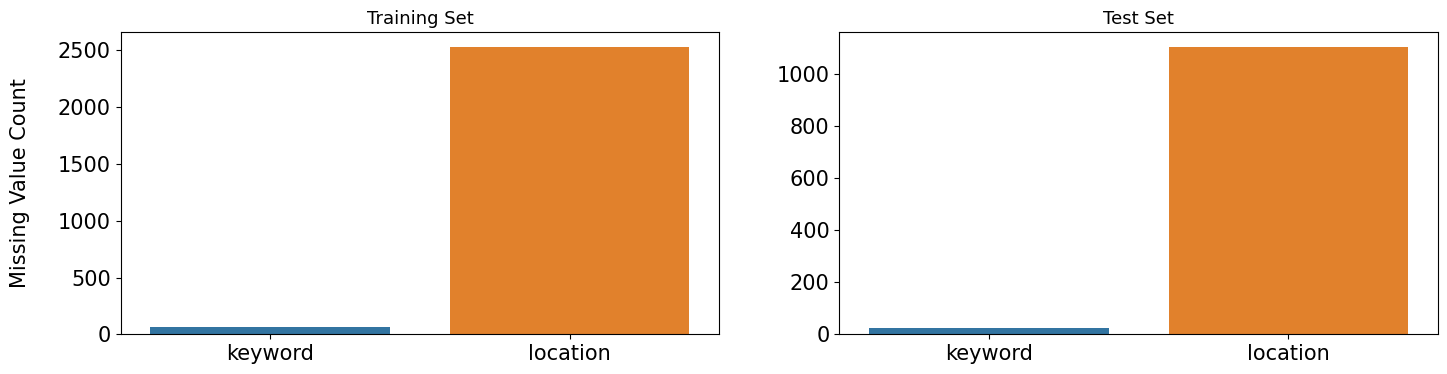

In [0]:
# missing_cols = ['keyword', 'location']

# fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

# sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
# sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

# axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
# axes[0].tick_params(axis='x', labelsize=15)
# axes[0].tick_params(axis='y', labelsize=15)
# axes[1].tick_params(axis='x', labelsize=15)
# axes[1].tick_params(axis='y', labelsize=15)

# axes[0].set_title('Training Set', fontsize=13)
# axes[1].set_title('Test Set', fontsize=13)

# plt.show()

# for df in [df_train, df_test]:
#     for col in ['keyword', 'location']:
#         df[col] = df[col].fillna(f'no_{col}')

In [0]:
# print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
# print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


In [0]:
df_train = df_train.loc[(df_train['rating'] <= 3) | (df_train['rating'] == 10)]
df_train['target']=df_train['rating'].apply(lambda x: 1 if x>=8 else 0)

In [0]:
df_test = df_test.loc[(df_test['rating'] <= 3) | (df_test['rating'] == 10)]
df_test['target']=df_test['rating'].apply(lambda x: 1 if x>=8 else 0)

In [0]:
df_train['text']=df_train['review']
df_test['text']=df_test['review']

In [0]:
df_train['keyword']=df_train['rating']
df_test['keyword']=df_test['rating']

In [0]:
df_train.drop(['uniqueID','date', 'condition', 'drugName', 'usefulCount', 'review'],axis=1,inplace=True)
df_test.drop(['uniqueID','date', 'condition', 'drugName', 'usefulCount', 'review'],axis=1,inplace=True)

In [0]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [0]:
df_train['unique_word_count'].median()

63.0

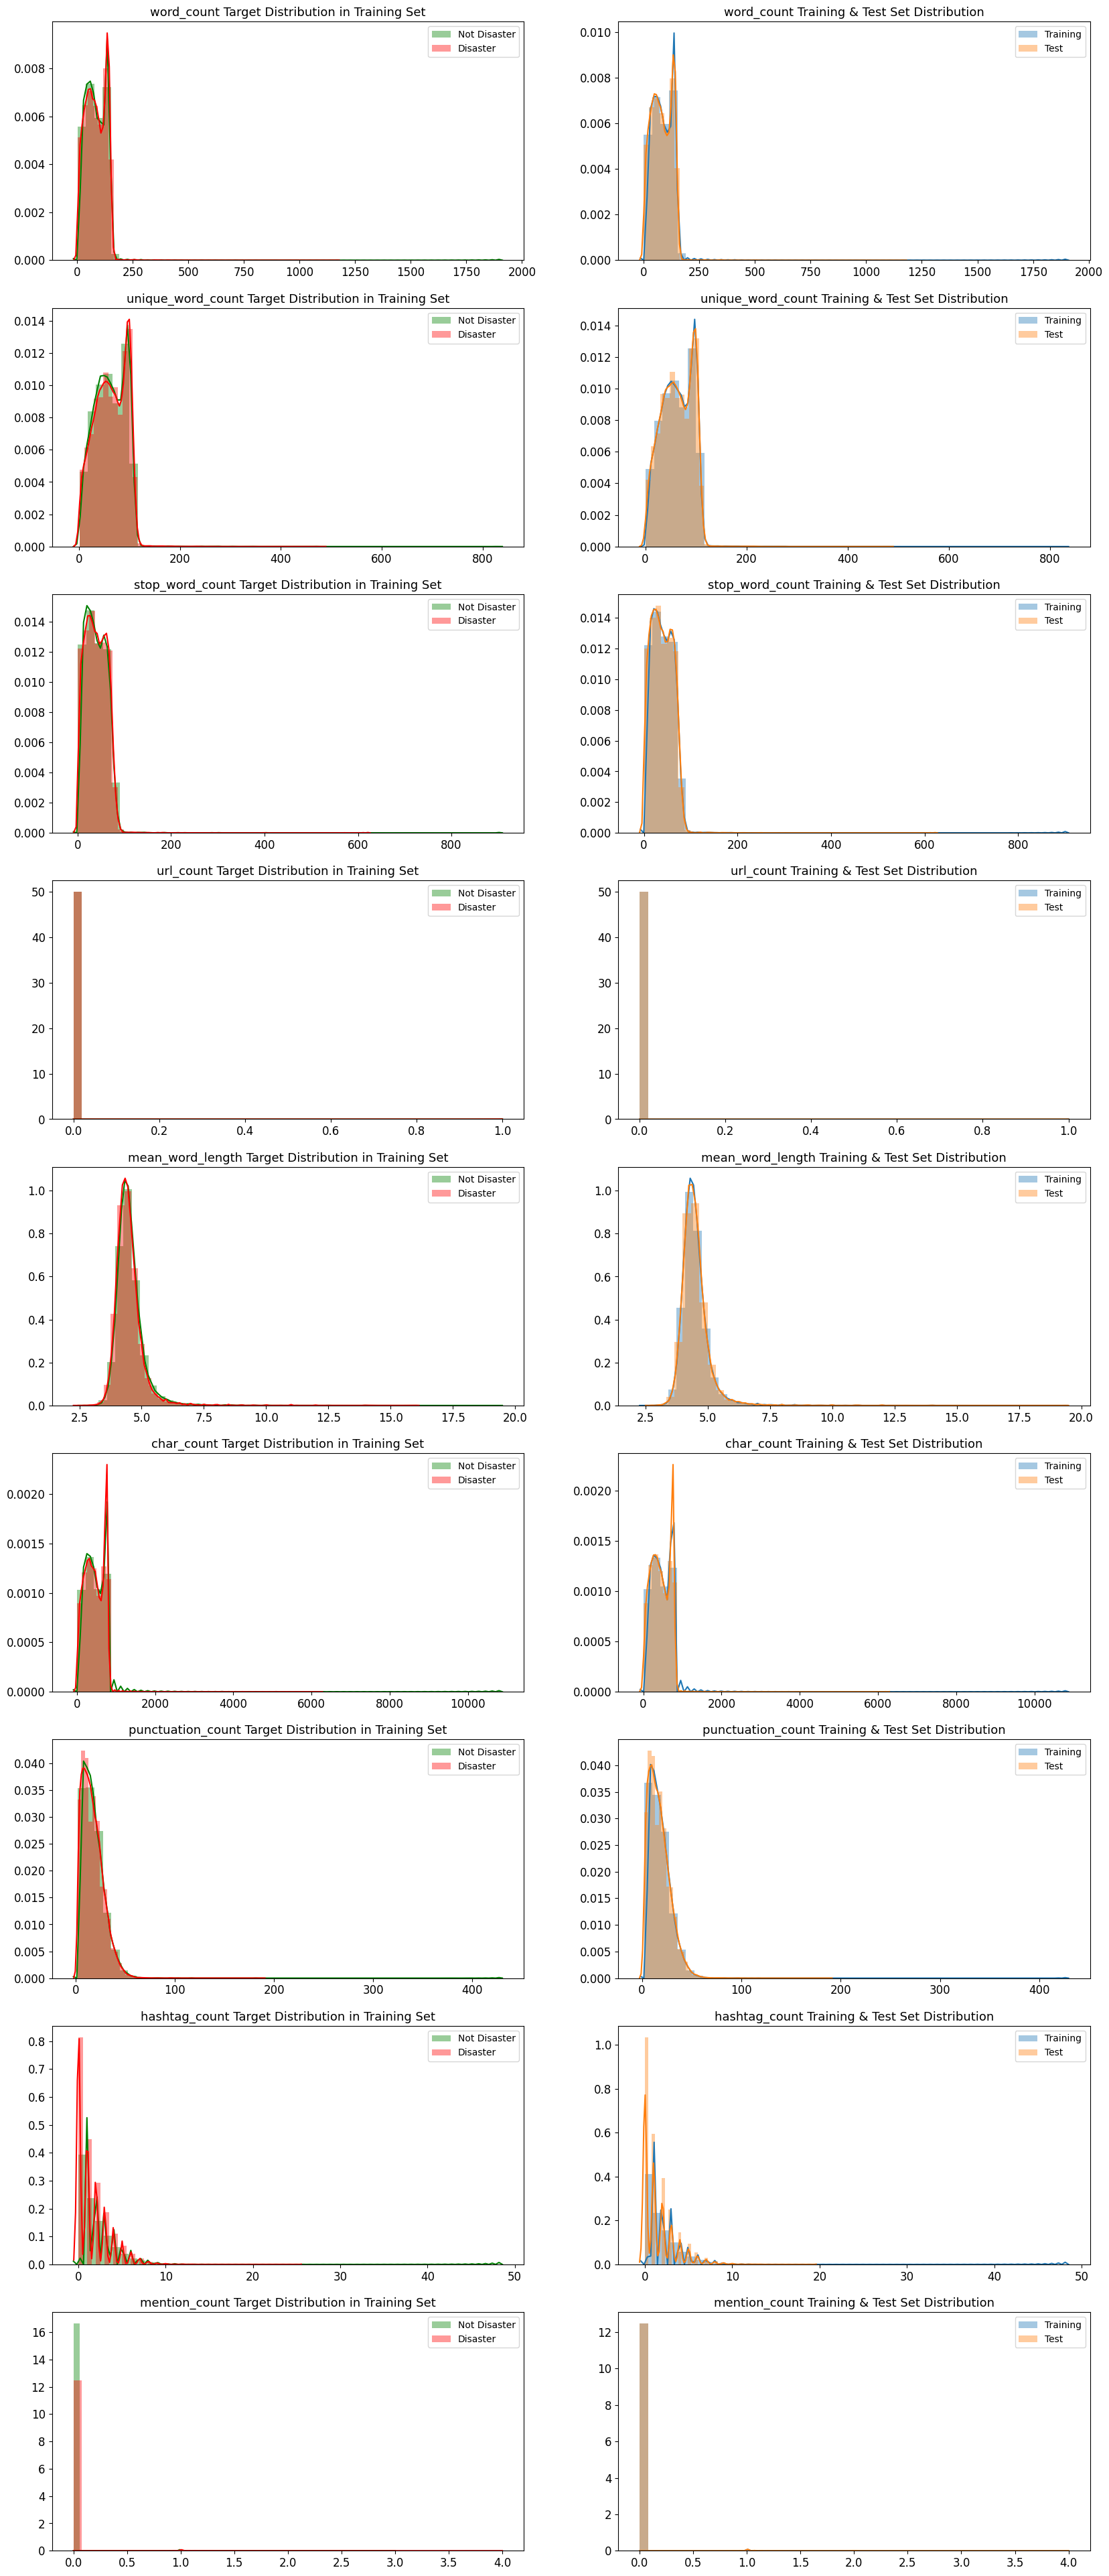

In [0]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

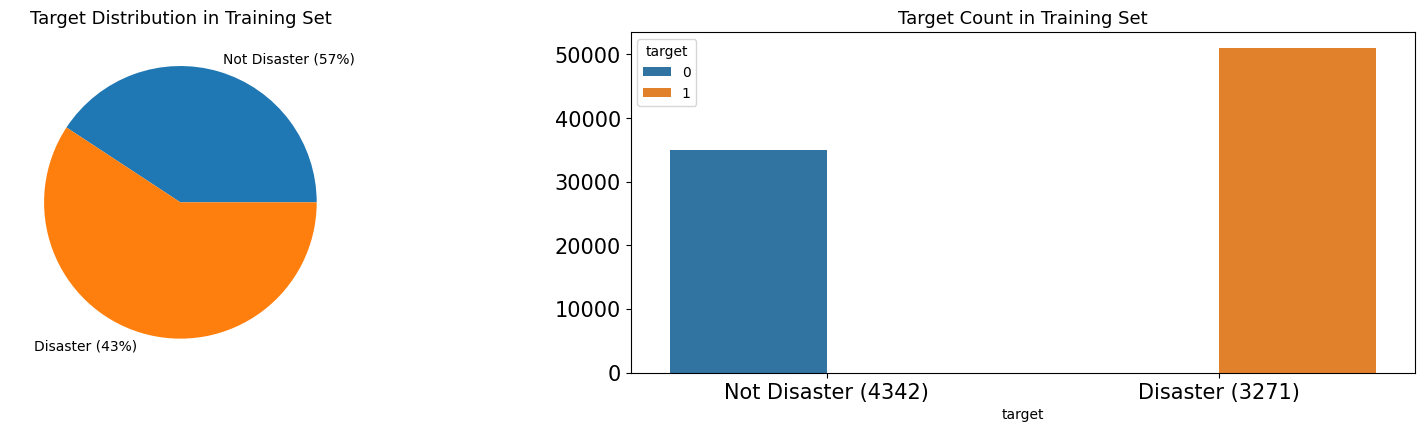

In [0]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['rating'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [0]:
%%time

glove_embeddings = np.load('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/crawl-300d-2M.pkl', allow_pickle=True)

CPU times: user 11.9 s, sys: 7.97 s, total: 19.9 s
Wall time: 1min 10s


In [0]:
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 32.00% of vocabulary and 89.57% of text in Training Set
GloVe Embeddings cover 37.50% of vocabulary and 89.54% of text in Test Set
FastText Embeddings cover 35.61% of vocabulary and 90.95% of text in Training Set
FastText Embeddings cover 41.72% of vocabulary and 90.94% of text in Test Set


In [0]:
%%time

def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)

    
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      

    
    return tweet

df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean(s))

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 60.41% of vocabulary and 96.24% of text in Training Set
GloVe Embeddings cover 64.97% of vocabulary and 96.24% of text in Test Set
FastText Embeddings cover 60.20% of vocabulary and 96.55% of text in Training Set
FastText Embeddings cover 64.89% of vocabulary and 96.55% of text in Test Set
CPU times: user 22.9 s, sys: 26.9 ms, total: 22.9 s
Wall time: 22.9 s


In [0]:
del glove_embeddings, fasttext_embeddings, train_glove_oov, test_glove_oov, train_fasttext_oov, test_fasttext_oov
gc.collect()

0

In [0]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['"I was prescribed Inderal to help with Primary Ortostatic Tremors. I did not get any relief with this medication for that condition. However. I discovered that whenever I stop taking Inderal, I end up with a migraine headache. I take 20 mg at bedtime. It makes me sleepy and gives me nightmares which continue to this day. However, the side effects are tolerable and well worth putting up with to prevent getting migraines. I highly recommend this medication for preventing migraines."']

In [0]:
df_train['target_relabeled'] = df_train['target'].copy() 

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

In [0]:
K = 2
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

DISASTER = df_train['target'] == 1
print('Whole Training Set Shape = {}'.format(df_train.shape))
print('Whole Training Set Unique keyword Count = {}'.format(df_train['keyword'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(df_train[DISASTER]['target_relabeled'].count(), df_train[~DISASTER]['target_relabeled'].count()))

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train['text_cleaned'], df_train['target']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, df_train['text_cleaned'].iloc[df_train.index.intersection(trn_idx)].shape, df_train['text_cleaned'].iloc[df_train.index.intersection(val_idx)].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, df_train['keyword'].iloc[df_train.index.intersection(trn_idx)].nunique(), df_train['keyword'].iloc[df_train.index.intersection(val_idx)].nunique()))    

Whole Training Set Shape = (86052, 15)
Whole Training Set Unique keyword Count = 4
Whole Training Set Target Rate (Disaster) 50989/35063 (Not Disaster)

Fold 1 Training Set Shape = (23006,) - Validation Set Shape = (22988,)
Fold 1 Training Set Unique keyword Count = 4 - Validation Set Unique keyword Count = 4

Fold 2 Training Set Shape = (22988,) - Validation Set Shape = (23006,)
Fold 2 Training Set Unique keyword Count = 4 - Validation Set Unique keyword Count = 4


In [0]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))  

In [0]:
%%time

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

CPU times: user 6.53 s, sys: 1.37 s, total: 7.9 s
Wall time: 8.11 s


In [0]:
class DisasterDetector:
    
    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        
        # BERT and Tokenization params
        self.bert_layer = bert_layer
        
        self.max_seq_length = max_seq_length        
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        
        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.models = []
        self.scores = {}
        
        
    def encode(self, texts):
                
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    
    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')    
        
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])   
        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)
        
        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model




    
    def train(self, X):
        
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['text_cleaned'], X['keyword'])):
            
            print('\nFold {}\n'.format(fold))
        
            X_trn_encoded = self.encode(X['text_cleaned'].iloc[df_train.index.intersection(trn_idx)].str.lower())
            y_trn = X['target_relabeled'].iloc[df_train.index.intersection(trn_idx)]
            X_val_encoded = self.encode(X['text_cleaned'].iloc[df_train.index.intersection(val_idx)].str.lower())
            y_val = X['target_relabeled'].iloc[df_train.index.intersection(val_idx)]
        
            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn), validation_data=(X_val_encoded, y_val))
            
            # Model
            model = self.build_model()        
            model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)
            
            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores                    
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores                    
                }
            }
                    
                
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
        
    def predict(self, X):
        
        X_test_encoded = self.encode(X['text_cleaned'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

In [0]:
clf = DisasterDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)

clf.train(df_train)


Fold 0

Epoch 1/10
715/715 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.7538 
Epoch: 1 - Training Precision: 0.836944 - Training Recall: 0.838466 - Training F1: 0.83767
Epoch: 1 - Validation Precision: 0.831003 - Validation Recall: 0.833324 - Validation F1: 0.832076
715/715 [==============================] - 30059s 42s/step - loss: 0.4933 - accuracy: 0.7538 - val_loss: 0.3637 - val_accuracy: 0.8370
Epoch 2/10
394/715 [===============>..............] - ETA: 1:51:25 - loss: 0.3416 - accuracy: 0.8499